In [2]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [3]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

ashkhagan_figshare_brain_tumor_dataset_path = kagglehub.dataset_download('ashkhagan/figshare-brain-tumor-dataset')
kishore8824_efficientnet_b4_pytorch_default_1_path = kagglehub.model_download('kishore8824/efficientnet-b4/PyTorch/default/1')

print('Data source import complete.')


100%|██████████| 839M/839M [00:10<00:00, 83.7MB/s]

Extracting files...



  0%|          | 0.00/67.7M [00:00<?, ?B/s]
  6%|▌         | 4.00M/67.7M [00:00<00:01, 41.5MB/s]
 12%|█▏        | 8.00M/67.7M [00:00<00:01, 39.5MB/s]
 25%|██▌       | 17.0M/67.7M [00:00<00:00, 62.8MB/s]
 35%|███▌      | 24.0M/67.7M [00:00<00:00, 50.4MB/s]
 58%|█████▊    | 39.0M/67.7M [00:00<00:00, 81.2MB/s]
 74%|███████▍  | 50.0M/67.7M [00:00<00:00, 90.4MB/s]
100%|██████████| 67.7M/67.7M [00:00<00:00, 85.0MB/s]

Data source import complete.


In [ ]:
import mahotas as mh

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2 as cv
import os
import glob
import scipy.io
from PIL import Image
import h5py
import pandas as pd
from sklearn.metrics import confusion_matrix
import skimage

In [2]:
from skimage import io
from skimage import feature,filters

In [3]:
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms,models
from torchvision.datasets import ImageFolder
import torch.functional as F
from torch.utils.data import DataLoader,TensorDataset,Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.init as init

In [4]:
pth = os.path.join('/kaggle/input/figshare-brain-tumor-dataset/dataset/data')

In [5]:
def load_mat_image(mat_file_path, image_key='cjdata'):
    with h5py.File(mat_file_path, 'r') as mat:
        image_data = np.array(mat['cjdata']['image'])
        mask_data = np.array(mat['cjdata']['tumorMask'])
        return image_data,mask_data
    raise ValueError(f"Could not find image data under key '{image_key}' in {mat_file_path}")

# Load image data from .mat file
image,masked = load_mat_image(os.path.join(pth,'1099.mat'))
#image = cv.convertScaleAbs(image)
#image = np.uint8(image)

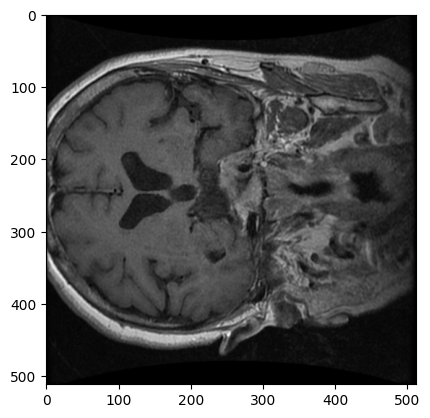

In [25]:
plt.imshow(image,cmap='gray')

In [9]:
gamma_img = np.power(image,0.8)

In [6]:
def safe_median_blur(img, ksize=3):
    img = np.array(img)

    # If float (e.g., after normalization or gamma), scale to uint16
    if img.dtype == np.float32 or img.dtype == np.float64:
        # Clip to [0, 1] if normalized, else assume raw
        if img.max() <= 1.0:
            img = (img * 65535).astype(np.uint16)  # Scale to 16-bit
        else:
            img = img.astype(np.uint16)

    # Now apply median blur (ksize must be odd and > 1)
    if ksize % 2 == 0:
        ksize += 1  # e.g., 2 → 3
    blurred = cv.medianBlur(img, ksize)

    return blurred

In [ ]:
median_img = safe_median_blur(gamma_img,3)

(<Axes: >, <matplotlib.image.AxesImage at 0x79405c3b7ed0>)

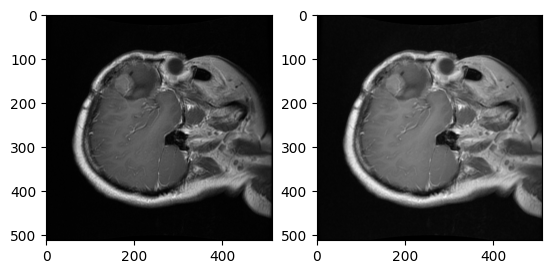

In [ ]:
plt.subplot(1,2,1),plt.imshow(image,cmap='gray')
plt.subplot(1,2,2),plt.imshow(median_img,cmap='gray')

(<Axes: >, <matplotlib.image.AxesImage at 0x79405c487250>)

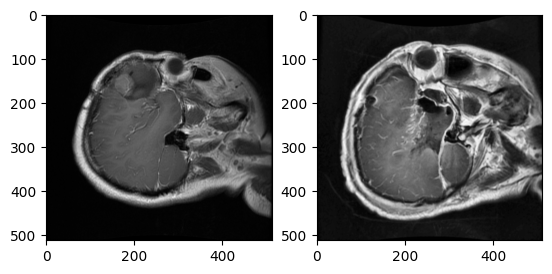

In [ ]:
plt.subplot(1,2,1),plt.imshow(image,cmap='gray')
plt.subplot(1,2,2),plt.imshow(gray_out,cmap='gray')

In [ ]:
trans = transform(median_img)
img = trans.permute(1,2,0)

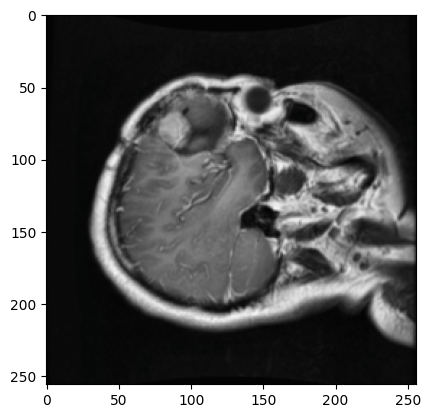

In [ ]:
plt.imshow(img)

In [ ]:
image_normalized = median_img.astype(np.float64) / median_img.max()
im = image_normalized*255.0
im = im.astype(np.uint8)
smoothed = filters.gaussian(im,sigma=1.0)
edges = feature.canny(smoothed, sigma=1.0, low_threshold=0.1, high_threshold=0.2)

Text(0.5, 1.0, 'Edge Negated')

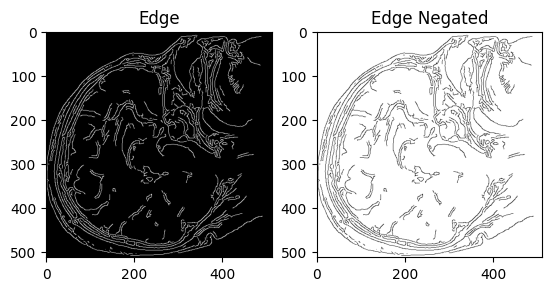

In [ ]:
plt.subplot(1,2,1);plt.imshow(edges,cmap='gray');plt.title('Edge')
plt.subplot(1,2,2);plt.imshow(1-edges,cmap='gray');plt.title('Edge Negated')

(<matplotlib.image.AxesImage at 0x7d94d229df10>,
 Text(0.5, 1.0, 'Edge Enhanced'))

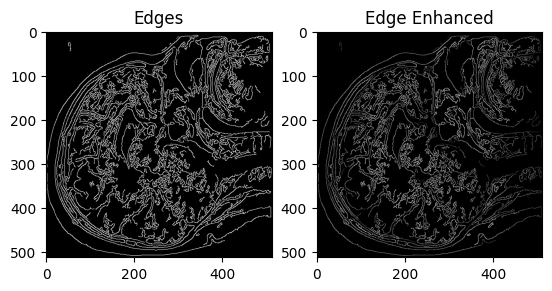

In [ ]:
#edges = 1-edges
edge_enhanced = cv.bitwise_or(img_out,img_out,mask=edges)
plt.subplot(1,2,1);plt.imshow(edges,cmap='gray'),plt.title('Edges')
plt.subplot(1,2,2);plt.imshow(edge_enhanced,cmap='gray'),plt.title('Edge Enhanced')

In [ ]:
edges = cv.Canny(gray_out,110,250)

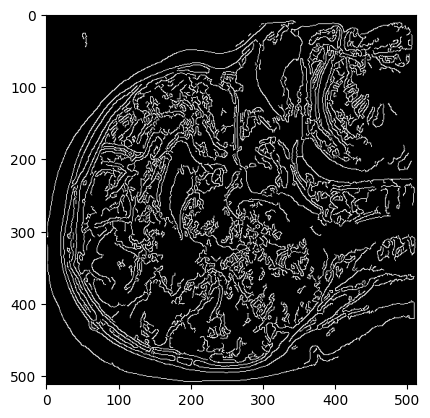

In [ ]:
plt.imshow(edges,cmap='gray')

In [ ]:
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img_np = cv.cvtColor(im,cv.COLOR_GRAY2RGB)
img_np = cv.GaussianBlur(img_np,(3,3),sigmaX=1.0)
img_lab = cv.cvtColor(img_np, cv.COLOR_RGB2LAB)
L = img_lab[:,:,0]
img_lab[:,:,0] = clahe.apply(L)
img_out = cv.cvtColor(img_lab, cv.COLOR_LAB2RGB)
gray_out = cv.cvtColor(img_out,cv.COLOR_RGB2GRAY)

### Sharpening

In [ ]:
blur = cv.GaussianBlur(img_out,(3,3),sigmaX = 1.0)
mask = img_out-blur
mask = mask.astype(np.float32)/mask.max()
mask = np.where(mask>mask.mean(),1,0)
out_img = cv.bitwise_and(img_out,img_out,mask = mask)

error: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'


(<Axes: title={'center': 'Image'}>,
 Text(0.5, 1.0, 'Image'))

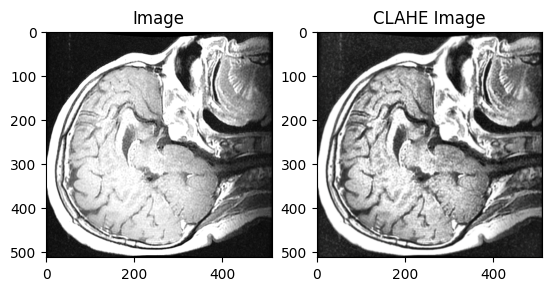

In [ ]:
plt.subplot(1,2,2),plt.imshow(img_out,cmap = 'gray'),plt.title('CLAHE Image')
plt.subplot(1,2,1),plt.imshow(image,cmap = 'gray'),plt.title('Image')

In [ ]:
edge = cv.Canny(img_out,110,250)

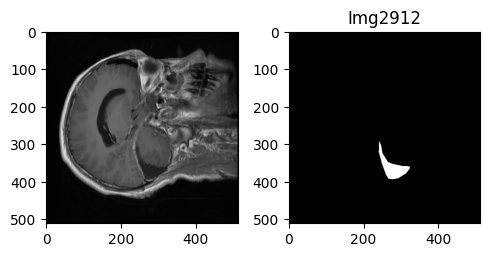

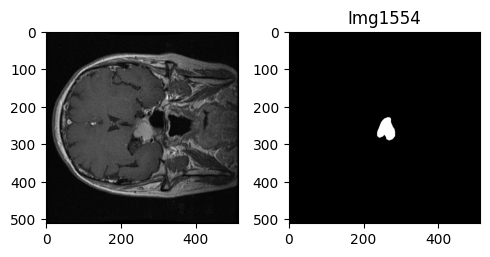

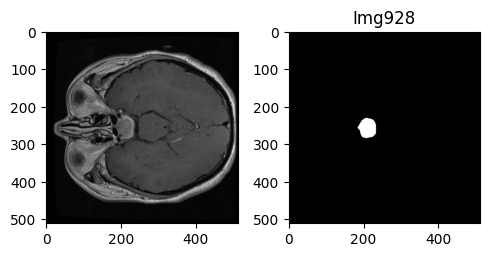

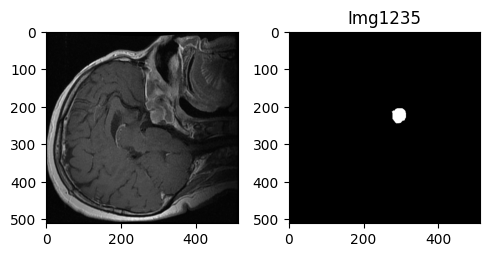

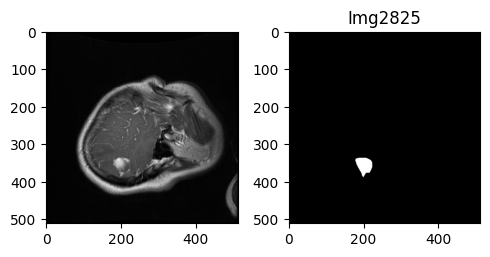

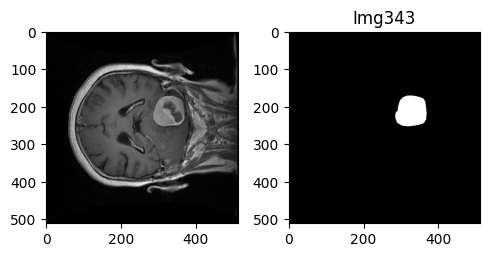

In [ ]:
a = os.listdir(pth)
j = range(1,13)
k=0
for i in range(0,len(a),500):
    if i>2500:
        break
    else:
        plt.figure(figsize=(5,20))
        plt.subplot(6,2,j[k])
        k+=1
        img,mask = load_mat_image(os.path.join(pth,a[i]))
        plt.imshow(img,cmap='gray')
        plt.subplot(6,2,j[k])
        plt.imshow(mask,cmap='gray')
        printable = a[i].split('.')[0]
        plt.title(f'Img{printable}')
        plt.tight_layout()
        k+=1
    plt.show()

In [ ]:
edge = np.where(edges==True,1,0)

In [ ]:
img_out.dtype

dtype('uint8')

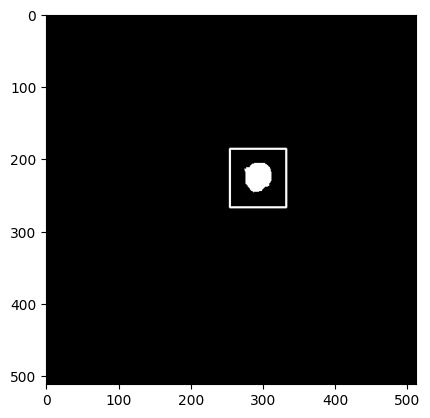

In [ ]:
plt.imshow(mask,cmap='gray')

### Preprocessing

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
files = []
for path in sorted(os.listdir(pth),key = lambda x:int(x.split('.')[0])):
    fullpath = os.path.join(pth,path)
    files.append(fullpath)

In [8]:
def box_coord_pred(mask):
    mask = np.array(mask).astype(np.uint8)
    contour,_ = cv.findContours(mask,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)
    box = []
    for cnt in contour:
        x,y,w,h = cv.boundingRect(cnt)
        box.append([x-10,y-10,w+20,h+20])
    box_coord = sorted(box,key=lambda x:x[2]*x[3],reverse = True)[0]
    box_coord = np.array(box_coord,dtype = np.float32)
    return box_coord

In [11]:
# class preprocess:
#     def __init__(self):
#         self.clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

#     def __call__(self, x, **params):
#         #img_np = np.power(img_np,0.8)
#         # Normalize to [0, 1] with float32
#         img_np = img_np.astype(np.float64)
#         max_val = img_np.max()
#         if max_val > 0:  # Avoid division by zero
#             img_np = img_np / (max_val + 1e-8)
#         else:
#             img_np = np.full_like(img_np, 1e-4)

#         # Convert to uint8 for OpenCV
#         img_np = img_np*255.0
#         img_np = img_np.astype(np.uint8)
#         #img_np = cv.medianBlur(img_np,3)
#         img_np = cv.cvtColor(img_np,cv.COLOR_GRAY2RGB)
#         # Apply CLAHE and other processing
#         img_np = cv.cvtColor(img_np, cv.COLOR_RGB2LAB)
#         img_np[:, :, 0] = self.clahe.apply(img_np[:, :, 0])
#         img_rgb_output = cv.cvtColor(img_np, cv.COLOR_LAB2RGB)
#         img_blurred = cv.GaussianBlur(img_rgb_output, (3, 3), sigmaX = 1)

#         img_pil = Image.fromarray(img_blurred)
#         return img_pil

class CLAHEPreprocess(A.ImageOnlyTransform):
    def __init__(self, clipLimit=2.0, tileGridSize=(8, 8), always_apply=True, p=1.0):
        super().__init__(always_apply=always_apply, p=p)
        self.clahe = cv.createCLAHE(
            clipLimit=clipLimit,
            tileGridSize=tileGridSize
        )

    def apply(self, image, **params):
        # image: numpy array, shape (H, W) or (H, W, C)
        img_np = image.astype(np.float64)

        max_val = img_np.max()
        if max_val > 0:
            img_np = img_np / (max_val + 1e-8)
        else:
            img_np = np.full_like(img_np, 1e-4)

        img_np = (img_np * 255.0).astype(np.uint8)

        # Ensure RGB
        if img_np.ndim == 2:
            img_np = cv.cvtColor(img_np, cv.COLOR_GRAY2RGB)
        elif img_np.shape[2] == 1:
            img_np = cv.cvtColor(img_np, cv.COLOR_GRAY2RGB)
            
        # LAB + CLAHE
        lab = cv.cvtColor(img_np, cv.COLOR_RGB2LAB)
        lab[:, :, 0] = self.clahe.apply(lab[:, :, 0])
        img_rgb = cv.cvtColor(lab, cv.COLOR_LAB2RGB)

        img_rgb = cv.GaussianBlur(img_rgb, (3, 3), sigmaX=1)

        return img_rgb.astype(np.float32)

In [40]:
Preprocess = CLAHEPreprocess()
processed_img = Preprocess(image)

/tmp/ipykernel_38/2031079908.py:31: UserWarning: Argument(s) 'always_apply' are not valid for transform BasicTransform
  super().__init__(always_apply=always_apply, p=p)


KeyError: 'You have to pass data to augmentations as named arguments, for example: aug(image=image)'

In [10]:
img,m,box = train_dataset.__getitem__(1000)
def visualize(img_tensor, box_norm, title=""):
    # Step 1: Convert [C, H, W] → [H, W, C]
    img = img_tensor.permute(1, 2, 0).cpu().numpy()  # (224, 224, 3)

    # Step 2: Denormalize (ImageNet stats) — broadcast correctly
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    img = img * std + mean   # This works: (224,224,3) * (3,) → broadcasting on last dim
    img = np.clip(img, 0, 1)

    # Step 3: Convert to uint8
    img = (img * 255).astype(np.uint8)

    # Step 4: Convert to BGR for OpenCV
    img_bgr = cv.cvtColor(img, cv.COLOR_RGB2BGR)

    # Step 5: Draw box
    x, y, w, h = (box_norm * 224).astype(int)  # Since image is 224x224
    cv.rectangle(img_bgr, (x, y), (x + w, y + h), (0, 0, 255), 2)  # Red

    # Step 6: Back to RGB for matplotlib
    img_rgb = cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB)

    # Step 7: Plot
    plt.figure(figsize=(6, 6))
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()
visualize(img, box, title="Image with Box")

NameError: name 'train_dataset' is not defined

In [12]:
# transform = transforms.Compose([
#     preprocess(),
#     transforms.Resize((256, 256)),
#     # transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),  # random crop + resize
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomVerticalFlip(p=0.5),
#     transforms.RandomApply([transforms.RandomRotation(30)], p=0.5),
#     # transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
#     # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#     transforms.RandomGrayscale(p=0.1),
#     # transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.3),
#     transforms.ToTensor(),
#     # transforms.RandomErasing(p=0.2, scale=(0.02, 0.1), ratio=(0.3, 3.3), value='random'),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])


# mask_transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Resize((256,256))
# ])

# val_transform = transforms.Compose([
#     transforms.Resize((256,256)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    CLAHEPreprocess(),
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    ToTensorV2(),
], additional_targets={'mask': 'mask'})

val_transform = A.Compose([
    A.Resize(256, 256),
    ToTensorV2(),
], additional_targets={'mask': 'mask'})



/tmp/ipykernel_38/4031716387.py:31: UserWarning: Argument(s) 'always_apply' are not valid for transform BasicTransform
  super().__init__(always_apply=always_apply, p=p)


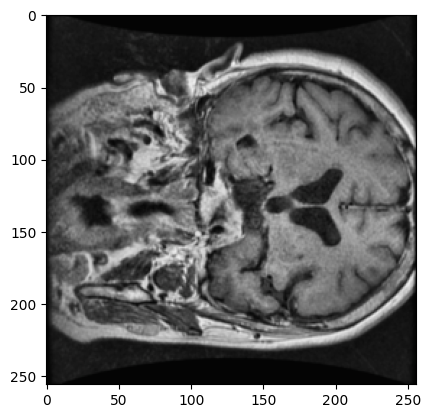

In [124]:
augment = train_transform(image=image,mask = masked)
img = augment['image']
mask = augment['mask']
plt.imshow(img.to(torch.uint8).permute(1,2,0))

In [16]:
import albumentations as A
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
], bbox_params=A.BboxParams(format='albumentations', label_fields=['labels']))

val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
], bbox_params=A.BboxParams(format='albumentations', label_fields=['labels']))

In [13]:
train_samples = round(0.9*len(files))
val_samples = round(0.1*len(files))

### ViT Dataset Creation

In [17]:
class CustomImageDataset(Dataset):
    def __init__(self, file_path, transform,mask_transform=None):
        self.pth = file_path
        self.transform = transform
        self.mask_transform = mask_transform
    def __len__(self):
        return len(self.pth)
    def __getitem__(self, idx):
        path = os.path.join(self.pth[idx])
        try:
            img, mask = load_mat_image(path)
            H,W = img.shape
            img = Image.fromarray(img).convert('RGB')
            img = np.array(img)
            img = img.astype(np.float32)
            mask = mask.astype(np.float32)
            if mask.sum() == 0:
                print(f"Warning: Empty mask at path: {path}")
                mask = torch.zeros_like(mask) + 1e-4
            # Validate image and mask
            if img is None or mask is None or img.size == 0 or mask.size == 0:
                raise ValueError(f"Invalid image or mask at path: {path}")
            if img.max() == 0:
                raise ValueError(f"All-zero image at path: {path}")

            #img = Image.fromarray(img)
            mask = Image.fromarray(mask).convert('L')
            box = box_coord_pred(mask)
            x,y,w,h = box
            box = np.array([x/W,y/H,(x+w)/W,(y+h)/H],dtype = np.float32)
            if self.transform:
                aug = transform(image=img, bboxes=[box], labels=['tumor'])
                img = torch.from_numpy(aug['image'])
                img = img.permute(2,0,1)
                box = aug['bboxes'][0]
                # box[0] = W - (box[0] + box[2])
                # box[1] = H - (box[1] + box[3])
            else:
                img = transforms.ToTensor()(img)

            if self.mask_transform:
                mask = self.mask_transform(mask)
            else:
                mask = transforms.ToTensor()(mask)

            mask = (mask > 0).float()
            return img, mask, box
        except Exception as e:
            print(f"Error loading image at index {idx}: {e}")
            # Return a default or skip; here, we raise the error for visibility
            raise e

train_dataset = CustomImageDataset(files[:train_samples], transform=transform)
val_dataset = CustomImageDataset(files[:val_samples], transform=val_transform)

In [18]:
def custom_collate_fn(batch):
    imgs, masks, boxes = zip(*batch)

    # Ensure images and masks are stacked with consistent sizes
    imgs = torch.stack(imgs)
    masks = torch.stack(masks)

    # # Convert boxes to tensor (assuming boxes are numpy arrays or lists)
    boxes = torch.tensor(boxes, dtype=torch.float32)

    return imgs, masks, boxes

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True, collate_fn=custom_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True, pin_memory=True, collate_fn=custom_collate_fn)

### Main Block Dataset

In [14]:
# class CustomImageDataset(Dataset):
#     def __init__(self, file_path, transform,mask_transform=None):
#         self.pth = file_path
#         self.transform = transform
#         self.mask_transform = mask_transform
#     def __len__(self):
#         return len(self.pth)
#     def __getitem__(self, idx):
#         path = os.path.join(self.pth[idx])
#         try:
#             img, mask = load_mat_image(path)
#             mask = mask.astype(np.float32)
#             if mask.sum() == 0:
#                 print(f"Warning: Empty mask at path: {path}")
#                 mask = torch.zeros_like(mask) + 1e-4 
#             # Validate image and mask
#             if img is None or mask is None or img.size == 0 or mask.size == 0:
#                 raise ValueError(f"Invalid image or mask at path: {path}")
#             if img.max() == 0:
#                 raise ValueError(f"All-zero image at path: {path}")
            
#             img = Image.fromarray(img)
#             mask = Image.fromarray(mask).convert('L')
            
#             if self.transform:
#                 img = self.transform(img)
#             else:
#                 img = transforms.ToTensor()(img)

#             if self.mask_transform:
#                 mask = self.mask_transform(mask)
#             else:
#                 mask = transforms.ToTensor()(mask)

#             mask = (mask > 0).float()
#             return img, mask
#         except Exception as e:
#             print(f"Error loading image at index {idx}: {e}")
#             # Return a default or skip; here, we raise the error for visibility
#             raise e

class CustomImageDataset(Dataset):
    def __init__(self, files, transform, val):
        self.files = files
        self.transform = transform
        self.val = val

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img, mask = load_mat_image(self.files[idx])

        if self.val == True:
            img_np = img.astype(np.float64)
            max_val = img_np.max()
            if max_val > 0:
                img_np = img_np / (max_val + 1e-8)
            else:
                img_np = np.full_like(img_np, 1e-4)
    
            img_np = (img_np * 255.0).astype(np.uint8)
            if img_np.ndim == 2:
                img = cv.cvtColor(img_np, cv.COLOR_GRAY2RGB)
                
        augmented = self.transform(image=img, mask=mask)
        img = augmented['image'].to(torch.float32)
        mask = augmented['mask']

        if not torch.is_tensor(mask):
            mask = torch.from_numpy(mask)

        mask = mask.unsqueeze(0).float()
        mask = (mask > 0).float()
        return img, mask

train_dataset = CustomImageDataset(files[:train_samples], transform=train_transform, val = False)
val_dataset = CustomImageDataset(files[:val_samples], transform=val_transform, val = True)

In [103]:
a,b = val_dataset.__getitem__(200)

In [105]:
a.shape

torch.Size([3, 256, 256])

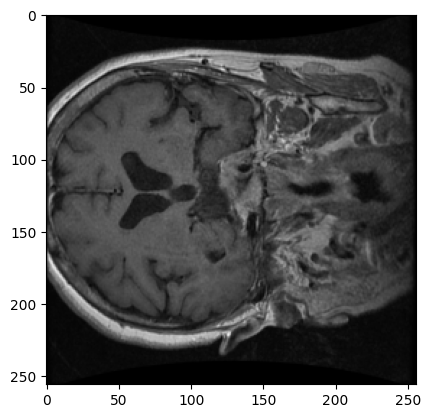

In [123]:
x = a.permute(1,2,0)
y = b.permute(1,2,0)
plt.imshow(x.to(torch.uint8))

In [15]:
def custom_collate_fn(batch):
    imgs, masks = zip(*batch)

    # Ensure images and masks are stacked with consistent sizes
    imgs = torch.stack(imgs)
    masks = torch.stack(masks)

    # # Convert boxes to tensor (assuming boxes are numpy arrays or lists)
    # boxes = torch.tensor(boxes, dtype=torch.float32)

    return imgs, masks

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True, collate_fn=custom_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True, pin_memory=True, collate_fn=custom_collate_fn)

### ViT

In [16]:
from torchvision.models import vit_b_16, ViT_B_16_Weights

# Load the pre-trained ViT model (base size, patch size 16)
model = vit_b_16(weights=None)

# Example: Print model architecture

#print(model)

In [17]:
model.heads = torch.nn.Sequential(
    torch.nn.Linear(model.heads.head.in_features, 4),
    torch.nn.Sigmoid(),
)

In [17]:
model

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [18]:
model.load_state_dict(torch.load('/kaggle/input/vit/pytorch/default/1/ViT_weights.pth'))

<All keys matched successfully>

In [19]:
for p in model.parameters():
    p.requires_grad = False

In [20]:
model = model.to(device)

In [20]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
criterion = nn.SmoothL1Loss()
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i,(img,_,box) in enumerate(train_dataloader):
        img,box = img.to(device),box.to(device)
        optimizer.zero_grad()
        outputs = model(img) # Use [CLS] token or pool

        loss = criterion(outputs, box)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        del img,box

    epoch_loss = running_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
# Define inference-only transform
infer_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and transform image
a = image[:,:,np.newaxis]
image = np.repeat(a,3,axis = 2)
img_np = infer_transform(image=image)['image']
img_tensor = torch.from_numpy(img_np).permute(2, 0, 1).float()
img_tensor = img_tensor.unsqueeze(0).to(device)

# Predict
model.eval()
with torch.no_grad():
    pred = model(img_tensor).cpu().numpy()[0]  # [x, y, w, h] in [0,1]

# Scale to original size
H, W = image.shape[:2]
x1 = int(pred[0] * W)
y1 = int(pred[1] * H)
x2 = int(pred[2] * W)
y2 = int(pred[3] * H)

# Draw
sample = image.copy()
cv.rectangle(sample, (x1, y1), (x2, y2), (255, 0, 0), 3)
plt.figure(figsize=(8, 8))
plt.imshow(sample)
plt.title("Predicted Tumor Bounding Box")
plt.axis('off')
plt.show()

## EfficientNet B4

In [21]:
import torchvision.models as models
from torchvision.models import EfficientNet_B4_Weights
# Load the pretrained EfficientNet B4 model|
# efficientnet_b4 = models.efficientnet_b4(weights=EfficientNet_B4_Weights.IMAGENET1K_V1)
efficientnet_b4 = models.efficientnet_b4(weights=None)

In [17]:
efficientnet_b4.classifier[1] = torch.nn.Sequential(
    torch.nn.Linear(in_features = efficientnet_b4.classifier[1].in_features,out_features = 512),
    torch.nn.Linear(in_features = 512,out_features = 3)
)

In [18]:
# Freeze everything first
for param in efficientnet_b4.parameters():
    param.requires_grad = False

# # Then unfreeze last few blocks (e.g., last 3)
for param in efficientnet_b4.features[-3:].parameters():
    param.requires_grad = True

In [46]:
for name, param in efficientnet_b4.named_parameters():
    print(name, param.requires_grad)

features.0.0.weight False
features.0.1.weight False
features.0.1.bias False
features.1.0.block.0.0.weight False
features.1.0.block.0.1.weight False
features.1.0.block.0.1.bias False
features.1.0.block.1.fc1.weight False
features.1.0.block.1.fc1.bias False
features.1.0.block.1.fc2.weight False
features.1.0.block.1.fc2.bias False
features.1.0.block.2.0.weight False
features.1.0.block.2.1.weight False
features.1.0.block.2.1.bias False
features.1.1.block.0.0.weight False
features.1.1.block.0.1.weight False
features.1.1.block.0.1.bias False
features.1.1.block.1.fc1.weight False
features.1.1.block.1.fc1.bias False
features.1.1.block.1.fc2.weight False
features.1.1.block.1.fc2.bias False
features.1.1.block.2.0.weight False
features.1.1.block.2.1.weight False
features.1.1.block.2.1.bias False
features.2.0.block.0.0.weight False
features.2.0.block.0.1.weight False
features.2.0.block.0.1.bias False
features.2.0.block.1.0.weight False
features.2.0.block.1.1.weight False
features.2.0.block.1.1.bia

In [30]:
efficientnet_b4.load_state_dict(torch.load('/kaggle/input/efficient-net-final/pytorch/default/1/efficientnet_weights.pth'))

<All keys matched successfully>

In [63]:
img = transform(image)
img = img.unsqueeze(0).to(device)
out = efficientnet_b4(img)
out.size()

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [42]:
label_map = {1:'meningioma',2:'glioma',3:'pituitary tumor'}

In [43]:
print(label_map[int(out.argmax())])

glioma


In [44]:
label

NameError: name 'label' is not defined

In [22]:
class CustomEfficientNet(nn.Module):
    def __init__(self,original_model_features):
        super().__init__()
        self.features = original_model_features
    def forward(self,x):
        encoder = {}
        x = self.features[0](x)
        x = self.features[1](x)
        x = self.features[2][0](x)
        encoder['block2a'] = x
        x = self.features[2][1:](x)
        x = self.features[3][0](x)
        encoder['block3a'] = x
        x = self.features[3][1:](x)
        x = self.features[4][0](x)
        encoder['block4a'] = x
        x = self.features[4][1:](x)
        x = self.features[5](x)
        x = self.features[6][0](x)
        encoder['block6a'] = x
        x = self.features[6][1:](x)
        x = self.features[7](x)
        x = self.features[8](x)
        encoder['block8'] = x
        return encoder

In [32]:
Efficient = CustomEfficientNet(efficientnet_b4.features)

In [33]:
img = transform(image)
img = img.unsqueeze(0)
out = Efficient(img)

In [23]:
class Encoder(nn.Module):
    def __init__(self, features, feature_size):
        super().__init__()
        self.efficient = CustomEfficientNet(features)
        self.feature_size = feature_size
        self.conv = nn.Conv2d(efficientnet_b4.features[8][0].out_channels, 256, kernel_size=3, padding=1)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(256, 128)
        self.proj = nn.Linear(128, 128*feature_size * feature_size)
        self.upsample1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.upsample2_depthwise = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1, groups=64)
        self.upsample2_pointwise = nn.ConvTranspose2d(64, 64, kernel_size=1)
        self.upsample3_depthwise = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1, groups=64)
        self.upsample3_pointwise = nn.ConvTranspose2d(64, 64, kernel_size=1)
        self.dropout = nn.Dropout(p=0.2)
        self.batch_norm1 = nn.BatchNorm2d(num_features = 64)
        self.batch_norm2 = nn.BatchNorm2d(num_features = 64)
        self.batch_norm3 = nn.BatchNorm2d(num_features = 64)
        self.relu = nn.ReLU(inplace = True)

    def forward(self, x):
        batch_size,_,_,_ = x.size()
        encode = {}
        batch_size = x.size(0)
        efficient_out = self.efficient(x)
        encode['efficientnet_res'] = efficient_out
        x = self.conv(efficient_out['block8'])
        encode['decode_in'] = x
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        mean = self.fc1(x)
        logvar = self.fc2(x)
        std = torch.exp(0.5 * logvar)
        noise = torch.randn(batch_size, 128, device=device)
        reconstruction = mean + std * noise
        encode['Mean'] = mean
        encode['Logvar'] = logvar
        encode['Latent'] = reconstruction
        out = self.proj(reconstruction)
        out = self.dropout(out)
        out = out.view(out.size(0), 128, self.feature_size, self.feature_size)
        encode['vae_res1'] = out
        out = self.upsample1(out)
        #out = out.flatten(dim = 1)
        out = self.relu(self.batch_norm1(out))
        encode['vae_res2'] = out
        
        out = self.upsample2_depthwise(out)
        out = self.upsample2_pointwise(out)
        out = self.relu(self.batch_norm2(out))
        
        encode['vae_res3'] = out
        out = self.upsample3_depthwise(out)
        out = self.upsample3_pointwise(out)
        out = self.relu(self.batch_norm3(out))
        
        encode['vae_res4'] = out
        return encode

In [35]:
encoder = Encoder(features = efficientnet_b4.features,feature_size = 8)

In [50]:
img = transform(image)
img = img.unsqueeze(0)
out = encoder(img)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

### Efficient Decoder

In [24]:
class SegmentBlock(nn.Module):
    def __init__(self,features,feature_size,alpha):
        super().__init__()
        self.encoder = Encoder(features = features,feature_size = feature_size)
        self.latent_proj = nn.Linear(128,64)
        #self.alpha = alpha
        self.alpha = nn.Parameter(torch.tensor(0.7))

        self.vae_cnn1 = nn.Conv2d(in_channels = 128,out_channels = 128,kernel_size = 3,padding = 1)
        self.vae_cnn2 = nn.Conv2d(in_channels = 64,out_channels = 128,kernel_size = 3,padding = 1)
        self.vae_cnn3 = nn.Conv2d(in_channels = 64,out_channels = 128,kernel_size = 3,padding = 1)
        self.vae_cnn4 = nn.Conv2d(in_channels = 64,out_channels = 128,kernel_size = 3,padding = 1)

        self.upsample1 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.upsample2 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.upsample3 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.upsample4 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.upsample5 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1)

        decode1_in = 256+128+efficientnet_b4.features[6][0].out_channels
        decode2_in = 192+efficientnet_b4.features[4][0].out_channels
        decode3_in = 192+efficientnet_b4.features[3][0].out_channels
        decode4_in = 192+efficientnet_b4.features[2][0].out_channels
        self.decoder1 = DecoderStage(decode1_in,64)
        self.decoder2 = DecoderStage(decode2_in,64)
        self.decoder3 = DecoderStage(decode3_in,64)
        self.decoder4 = DecoderStage(decode4_in,64,dilation = 4)

        self.cross_attn = nn.MultiheadAttention(embed_dim = 64,num_heads = 4,batch_first = True)
        self.final_conv = nn.Conv2d(64,1,kernel_size = 3,padding = 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self,x):
        residuals = self.encoder(x)
        vae = self.vae_cnn1(residuals['vae_res1'])
        out = torch.cat([residuals['decode_in'],residuals['efficientnet_res']['block6a'],vae],dim = 1)
        out = self.decoder1(out)

        out = self.upsample1(out)
        vae = self.vae_cnn2(residuals['vae_res2'])
        out = torch.cat([out,residuals['efficientnet_res']['block4a'],vae],dim = 1)
        out = self.decoder2(out)

        out = self.upsample2(out)
        vae = self.vae_cnn3(residuals['vae_res3'])
        out = torch.cat([out,residuals['efficientnet_res']['block3a'],vae],dim = 1)
        out = self.decoder3(out)

        out = self.upsample3(out)
        vae = self.vae_cnn4(residuals['vae_res4'])
        out = torch.cat([out,residuals['efficientnet_res']['block2a'],vae],dim = 1)
        out = self.decoder4(out)

        out = self.upsample4(out)

        batch_size,channels,H,W = out.size()
        x_flat = out.view(batch_size, channels, H * W).transpose(1, 2)
        vae_latent = residuals['Latent'].unsqueeze(1)
        vae_latent = self.latent_proj(vae_latent)
        attended, _ = self.cross_attn(vae_latent, x_flat, x_flat)
        attenede = attended.transpose(1,2)
        attended = attended.view(batch_size, channels, 1, 1)
        attended = attended.expand(-1, -1, H, W)
        x = out + attended
        x = self.upsample5(x)
        x = self.final_conv(x)
        x = self.sigmoid(x)
        return x,residuals['Mean'],residuals['Logvar']

In [27]:
decoder = SegmentBlock(features = efficientnet_b4.features,feature_size = 8,alpha = 0.7)

In [28]:
def init_weights_mixed(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            if isinstance(m, nn.Linear) and hasattr(m, 'is_output') and m.is_output:
                # For final sigmoid layer
                init.xavier_uniform_(m.weight)
            else:
                # For ReLU layers
                init.kaiming_normal_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                init.zeros_(m.bias)

In [29]:
decoder.encoder.efficient.load_state_dict(torch.load('/kaggle/input/efficient-net-final/pytorch/default/1/efficientnet_weights.pth'),strict = False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['classifier.1.0.weight', 'classifier.1.0.bias', 'classifier.1.1.weight', 'classifier.1.1.bias'])

In [39]:
#decoder.apply(init_weights_mixed)
decoder = decoder.to(device)

In [93]:
aug = train_transform(image=image,mask = masked)
img = aug['image']
img = img.unsqueeze(0).to(device)
out = decoder(img)

In [ ]:
img = transform(image)
img = img.unsqueeze(0).to(device)
pred_box = model(img)
pred_box = pred_box.detach().cpu().numpy().astype(np.int8).reshape(4,)
pred_box

array([-82, -59, 102, 100], dtype=int8)

(<Axes: title={'center': 'Pred Box[-82 -59 102 100]'}>,
 Text(0.5, 1.0, 'Pred Box[-82 -59 102 100]'))

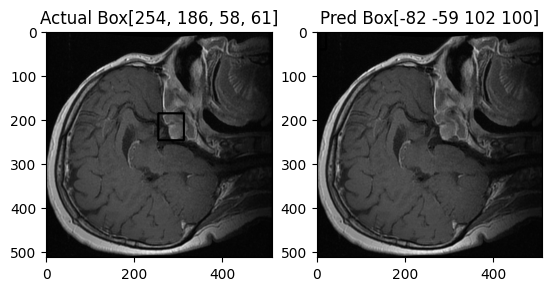

In [ ]:
actual = box_coord_pred(mask)
img1 = image.copy()
img2 = image.copy()
cv.rectangle(img1,(actual[0],actual[1]),(actual[0]+actual[2],actual[1]+actual[3]),(0,0,255),4)
cv.rectangle(img2,(pred_box[0],pred_box[1]),(pred_box[0]+pred_box[2],pred_box[1]+pred_box[3]),(0,0,255),4)
plt.subplot(1,2,1),plt.imshow(img1,cmap='gray'),plt.title(f"Actual Box{actual}")
plt.subplot(1,2,2),plt.imshow(img2,cmap='gray'),plt.title(f"Pred Box{pred_box}")

### Inception Dense Block

In [ ]:
class InceptionDense(nn.Module):
    def __init__ (self,in_channels,out_channels,use_pool):
        super().__init__()
        self.conv_11 = nn.Conv2d(in_channels,in_channels*3,kernel_size = 1)
        self.conv_13 = nn.Conv2d(in_channels,in_channels*3,kernel_size = 3,padding = 1)
        self.conv_15 = nn.Conv2d(in_channels,in_channels*3,kernel_size = 5,padding = 2)
        self.conv_21 = nn.Conv2d(in_channels*9,out_channels,kernel_size = 1)
        self.conv_23 = nn.Conv2d(in_channels*9,out_channels,kernel_size = 3,padding = 1)
        self.conv_25 = nn.Conv2d(in_channels*9,out_channels,kernel_size = 5,padding = 2)
        self.maxpool = nn.MaxPool2d(kernel_size = 2,stride = 2)
        self.activation1 = nn.Softplus()
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.activation2 = nn.Softplus()
        self.use_pool = use_pool
    def forward(self,x):
        conv1 = self.conv_11(x)
        conv2 = self.conv_13(x)
        conv3 = self.conv_15(x)
        concat = torch.cat([conv1,conv2,conv3],dim = 1)
        out1 = self.activation1(concat)
        conv1 = self.conv_21(out1)
        conv2 = self.conv_23(out1)
        conv3 = self.conv_25(out1)
        concat = torch.cat([conv1,conv2,conv3,x],dim = 1)
        out = self.activation2(concat)
        if self.use_pool:
            out = self.maxpool(out)
        out = self.batchnorm(out)
        return out

### Depthwise seperable

In [ ]:
class DepthSeperable(nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels,in_channels,stride = 1,kernel_size = 3,groups = in_channels)
        self.pointwise = nn.Conv2d(in_channels,out_channels,kernel_size = 1)
    def forward(self,x):
        depth = self.depthwise(x)
        out = self.pointwise(depth)
        return out

### Encoder Block

In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_channels, feature_size, num_blocks=20, base_channels=64, max_pools=5):
        super().__init__()
        # self.inceptiondense = InceptionDense()
        # self.deptwise = DepthSeperable
        self.feature_size = feature_size
        self.blocks = nn.ModuleList()
        self.base_channels = base_channels
        pool_count = 0
        self.cnn1 = nn.Conv2d(in_channels = in_channels,out_channels = 32,kernel_size = 3)
        self.cnn2 = nn.Conv2d(in_channels = 32, out_channels = 64,kernel_size = 3)
        current_channels = 64

        for i in range(num_blocks):
            if i % 2 == 0:  # InceptionDense
                use_pool = 1 if (i%4 == 0 and pool_count<max_pools) else 0 # Apply pooling only for first max_pools blocks
                block = InceptionDense(
                    in_channels=current_channels,
                    out_channels=base_channels,
                    use_pool=use_pool
                )
                current_channels = base_channels * 4
                if use_pool:
                    pool_count += 1
            else:  # DepthSeperable
                block = DepthSeperable(
                    in_channels=current_channels,
                    out_channels=base_channels
                )
                current_channels = base_channels

            self.blocks.append(block)
        self.conv = nn.Conv2d(base_channels,128,kernel_size = 3)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(base_channels,128)
        self.fc2 = nn.Linear(base_channels,128)
        self.proj = nn.Linear(base_channels,self.feature_size,self.feature_size)
        self.upsample1 = nn.ConvTranspose2d(base_channels,64,kernel_size = 3)
        self.upsample2 = nn.ConvTranspose2d(64,64,kernel_size = 3,groups = 64)
        self.upsample3 = nn.ConvTranspose2d(64,64,kernel_size = 3,groups = 64)
        self.upsample4 = nn.ConvTranspose2d(64,64,kernel_size = 3,groups = 64)
        self.noise = torch.randn(1,128)

    def forward(self, x):
        x = self.cnn1(x)
        x = self.cnn2(x)
        print("First conv size : ",x.size())
        for i,block in enumerate(self.blocks):
            x = block(x)
            print(f'block{i} size : ',x.size())
        out = self.conv(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        mean = self.fc1(x)
        logvar = self.fc2(x)
        std = torch.exp(logvar*0.5)
        reconstruction = mean + std*noise
        out = self.proj(reconstruction)
        out = out.view(out.size(0),self.base_channels,self.feature_size,self.feature_size)
        out = self.upsample1(out)
        print("upsample size : ",out.size())
        out = self.upsample2(out)
        print("upsample size : ",out.size())
        out = self.upsample3(out)
        print("upsample size : ",out.size())
        out = self.upsample4(out)
        print("upsample size : ",out.size())
        return out

In [ ]:
class DepthSeperable(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, stride=1, kernel_size=3, groups=in_channels, padding=1)  # Added padding=1
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        depth = self.depthwise(x)
        out = self.pointwise(depth)
        return out

class InceptionDense(nn.Module):
    def __init__(self, in_channels, out_channels, use_pool):
        super().__init__()
        self.conv_11 = nn.Conv2d(in_channels, in_channels*3, kernel_size=1)
        self.conv_13 = nn.Conv2d(in_channels, in_channels*3, kernel_size=3, padding=1)
        self.conv_15 = nn.Conv2d(in_channels, in_channels*3, kernel_size=3, padding=2, dilation=2)
        self.conv_21 = nn.Conv2d(in_channels*9, out_channels, kernel_size=1)
        self.conv_23 = nn.Conv2d(in_channels*9, out_channels, kernel_size=3, padding=1)
        self.conv_25 = nn.Conv2d(in_channels*9, out_channels, kernel_size=5, padding=2)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.activation1 = nn.Softplus()
        self.batchnorm = nn.BatchNorm2d(out_channels * 3 + in_channels)  # Updated for concat
        self.activation2 = nn.Softplus()
        self.use_pool = use_pool

    def forward(self, x):
        conv1 = self.conv_11(x)
        conv2 = self.conv_13(x)
        conv3 = self.conv_15(x)
        concat = torch.cat([conv1, conv2, conv3], dim=1)
        out1 = self.activation1(concat)
        conv1 = self.conv_21(out1)
        conv2 = self.conv_23(out1)
        conv3 = self.conv_25(out1)
        concat = torch.cat([conv1, conv2, conv3, x], dim=1)
        out = self.activation2(concat)
        if self.use_pool:
            out = self.maxpool(out)
        out = self.batchnorm(out)
        return out

class Encoder(nn.Module):
    def __init__(self, in_channels, feature_size, num_blocks=20, base_channels=64, max_pools=5):
        super().__init__()
        self.feature_size = feature_size
        self.blocks = nn.ModuleList()
        self.base_channels = base_channels
        pool_count = 0
        self.cnn1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, padding=1)
        self.cnn2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        current_channels = 64
        for i in range(num_blocks):
            if i % 2 == 0:  # InceptionDense
                use_pool = True if (i%4==0 and pool_count<max_pools) else False
                block = InceptionDense(
                    in_channels=current_channels,
                    out_channels=base_channels,
                    use_pool=use_pool
                )
                current_channels = base_channels * 3 + current_channels  # 3*base_channels + in_channels
                if use_pool:

                    pool_count += 1
            else:  # DepthSeperable
                block = DepthSeperable(
                    in_channels=current_channels,
                    out_channels=base_channels
                )
                current_channels = base_channels
            self.blocks.append(block)
        self.conv = nn.Conv2d(current_channels, 128, kernel_size=3, padding=1)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(128, 128)
        self.fc2 = nn.Linear(128, 128)
        self.proj = nn.Linear(128, 128*feature_size * feature_size)
        self.upsample1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.upsample2 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1, groups=64)
        self.upsample3 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1, groups=64)
        self.upsample4_depthwise = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1, groups=64)
        self.upsample4_pointwise = nn.ConvTranspose2d(64, 64, kernel_size=1)
        self.upsample5_depthwise = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1, groups=64)
        self.upsample5_pointwise = nn.ConvTranspose2d(64, 64, kernel_size=1)

    def forward(self, x):
        encode = {}
        batch_size = x.size(0)
        x = self.cnn1(x)
        x = self.cnn2(x)
        encode['res1'] = x
        for i,block in enumerate(self.blocks):
            x = block(x)
            if i == 3:
                encode['res2'] = x
            elif i == 7:
                encode['res3'] = x
            elif i == 11:
                encode['res4'] = x
            elif i == 15:
                encode['res5'] = x

        decode_in = self.conv(x)
        x = self.global_pool(decode_in)
        x = x.view(x.size(0), -1)
        mean = self.fc1(x)
        logvar = self.fc2(x)
        std = torch.exp(0.5 * logvar)
        noise = torch.randn(batch_size, 128, device=device)
        reconstruction = mean + std * noise
        encode['Mean'] = mean
        encode['Logvar'] = logvar
        encode['Latent'] = reconstruction
        out = self.proj(reconstruction)
        out = out.view(out.size(0), 128, self.feature_size, self.feature_size)
        out = self.upsample1(out)
        encode['vae_res1'] = out
        out = self.upsample2(out)
        encode['vae_res2'] = out
        out = self.upsample3(out)
        encode['vae_res3'] = out
        out = self.upsample4_depthwise(out)
        out = self.upsample4_pointwise(out)
        encode['vae_res4'] = out
        out = self.upsample4_depthwise(out)
        out = self.upsample4_pointwise(out)
        encode['vae_res5'] = out
        return decode_in,encode

### Attention

In [25]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)  # GAP to [batch, channels, 1, 1]
        self.excitation = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        batch, channels, _, _ = x.size()
        y = self.squeeze(x).view(batch, channels)
        y = self.excitation(y).view(batch, channels, 1, 1)
        return x * y  # Broadcasts weights across H, W

### Decoder Layer

In [26]:
class DecoderStage(nn.Module):
    def __init__(self, in_channels, out_channels, dilation=2, reduction=16):
        super().__init__()
        self.dilated_conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=dilation, dilation=dilation)
        self.activation = nn.ReLU()
        self.conv_1x1 = nn.Conv2d(1, in_channels, kernel_size=1)
        self.se = SEBlock(in_channels, reduction=reduction)
        self.refine_conv = nn.Conv2d(in_channels,out_channels,kernel_size = 3,padding = 1)

    def forward(self, x):
        dilated = self.activation(self.dilated_conv(x))
        channel_mean = torch.mean(dilated, dim=1, keepdim=True)
        mean_refined = self.conv_1x1(channel_mean)
        combined = dilated + mean_refined
        attended = self.se(combined)
        out = self.refine_conv(attended)
        return out

### Final Layer

In [ ]:
class SegmentBlock(nn.Module):
    def __init__(self,in_channels,feature_size):
        super().__init__()
        self.in_channels = in_channels
        self.feature_size = feature_size
        self.latent_proj = nn.Linear(128,64)
        self.encoder = Encoder(in_channels = self.in_channels,feature_size = self.feature_size)

        self.vae_cnn1 = nn.Conv2d(in_channels = 64,out_channels = 128,kernel_size = 3,padding = 1)
        self.vae_cnn2 = nn.Conv2d(in_channels = 64,out_channels = 128,kernel_size = 3,padding = 1)
        self.vae_cnn3 = nn.Conv2d(in_channels = 64,out_channels = 128,kernel_size = 3,padding = 1)
        self.vae_cnn4 = nn.Conv2d(in_channels = 64,out_channels = 128,kernel_size = 3,padding = 1)
        self.vae_cnn5 = nn.Conv2d(in_channels = 64,out_channels = 128,kernel_size = 3,padding = 1)

        self.upsample1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.upsample2 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1, groups=64)
        self.upsample3 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1, groups=64)
        self.upsample4 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.upsample5 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1)

        self.decoder1 = DecoderStage(256,64)
        self.decoder2 = DecoderStage(256,64)
        self.decoder3 = DecoderStage(256,64)
        self.decoder4 = DecoderStage(256,64,dilation = 4)
        self.decoder5 = DecoderStage(256,64,dilation = 8)

        self.cross_attn = nn.MultiheadAttention(embed_dim = 64,num_heads = 4,batch_first = True)
        self.final_conv = nn.Conv2d(64,1,kernel_size = 3,padding = 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self,x):
        encode = self.encoder(x)
        decode_in,residuals = encode

        out = self.upsample1(decode_in)
        vae = self.vae_cnn1(residuals['vae_res1'])
        out = torch.cat([out,residuals['res5'],vae],dim = 1)
        out = self.decoder1(out)

        out = self.upsample2(out)
        vae = self.vae_cnn2(residuals['vae_res2'])
        out = torch.cat([out,residuals['res4'],vae],dim = 1)
        out = self.decoder2(out)

        out = self.upsample3(out)
        vae = self.vae_cnn3(residuals['vae_res3'])
        out = torch.cat([out,residuals['res3'],vae],dim = 1)
        out = self.decoder3(out)

        out = self.upsample4(out)
        vae = self.vae_cnn4(residuals['vae_res4'])
        out = torch.cat([out,residuals['res2'],vae],dim = 1)
        out = self.decoder4(out)

        out = self.upsample5(out)
        vae = self.vae_cnn5(residuals['vae_res5'])
        out = torch.cat([out,residuals['res1'],vae],dim = 1)
        out = self.decoder4(out)

        batch_size,channels,H,W = out.size()
        x_flat = out.view(batch_size, channels, H * W).transpose(1, 2)
        vae_latent = residuals['Latent'].unsqueeze(1)
        vae_latent = self.latent_proj(vae_latent)
        attended, _ = self.cross_attn(vae_latent, x_flat, x_flat)
        # attended = attended.expand(batch_size,224,224,channels)
        # attn_weights = torch.softmax(torch.bmm(vae_latent, x_flat.transpose(1, 2)), dim=-1)  # [1, 1, 224*224]
        # attended = torch.bmm(attn_weights, x_flat)  # [1, 1, 64]
        # # Expand to full spatial size
        # # attended = attended.transpose(1, 2).view(batch_size, channels, 1, 1)  # [1, 64, 1, 1]
        # # attended = attended.expand(-1, -1, H, W)  # [1, 64, 224, 224]
        attenede = attended.transpose(1,2)
        attended = attended.view(batch_size, channels, 1, 1)   # [B, 64, 1, 1]
        attended = attended.expand(-1, -1, H, W)
        x = out + attended
        x = self.final_conv(x)
        x = self.sigmoid(x)
        return x,residuals['Mean'],residuals['Logvar']

In [ ]:
SegmentModel = SegmentBlock(in_channels = 3,feature_size = 7)

In [ ]:
SegmenModel = SegmentModel.to(device)

In [ ]:
img = transform(image)
img = img.unsqueeze(0).to(device)
output = SegmentModel(img)
print(output[0].size())

torch.Size([1, 64, 224, 224])
vae latent size :  torch.Size([1, 1, 64])
torch.Size([1, 1, 224, 224])


### Segmentation Model Training

In [30]:
def iou_loss(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred) if pred.min() < 0 or pred.max() > 1 else pred

    # flatten spatial dims
    pred   = pred.view(pred.size(0), pred.size(1), -1)      # (B,C,N)
    target = target.view(target.size(0), target.size(1), -1)

    intersection = (pred * target).sum(dim=2)               # (B,C)
    union        = pred.sum(dim=2) + target.sum(dim=2) - intersection
    iou          = (intersection + smooth) / (union + smooth)   # (B,C)
    return 1.0 - iou.mean()

In [31]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    def forward(self, inputs, targets):
        # Flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        return 1 - dice

In [32]:
class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.3, beta=0.7, smooth=1e-6):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs) if inputs.min() < 0 or inputs.max() > 1 else inputs
        inputs = inputs.view(inputs.size(0), -1)
        targets = targets.view(targets.size(0), -1)
        tp = (inputs * targets).sum(dim=1)
        fp = (inputs * (1 - targets)).sum(dim=1)
        fn = ((1 - inputs) * targets).sum(dim=1)
        tversky = (tp + self.smooth) / (tp + self.alpha * fp + self.beta * fn + self.smooth)
        return 1 - tversky.mean()

In [33]:
class CombinedLoss(nn.Module):
    def __init__(self, dice_weight=0.5):
        super().__init__()
        self.beta = 1e-3
        self.dice = DiceLoss()
        self.tversky = TverskyLoss()
        self.dice_weight = dice_weight
    def forward(self, inputs, targets, mu, logvar):
        pred = torch.nan_to_num(inputs, nan=0.5, posinf=1.0, neginf=0.0).to(device)
        mu = torch.clamp(mu, -10, 10)
        logvar = torch.clamp(logvar, -10,10)
        dice = self.dice_weight * self.dice(inputs, targets) + (1 - self.dice_weight) * self.tversky(inputs, targets)
        kl = kl_divergence(mu,logvar)
        return dice + self.beta*kl

In [34]:
def kl_divergence(mu, logvar):
    # 0.5 * Σ (1 + log(σ²) - μ² - σ²)
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    return kl.mean()

### Training - 1

In [ ]:
beta = 1.0
optimizer = optim.Adam(SegmentModel.parameters(), lr=1e-3)
num_epochs = 10
for epoch in range(num_epochs):
    SegmentModel.train()
    running_loss = 0.0
    for img,mask,_ in dataloader:
        img,mask = img.to(device),mask.to(device)
        optimizer.zero_grad()
        outputs,mu,logvar = SegmentModel(img)
        iou = iou_loss(outputs,mask)
        kl_l = kl_divergence(mu, logvar)
        loss = iou+beta*kl_l

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

/tmp/ipykernel_36/2403214302.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  boxes = torch.tensor(boxes, dtype=torch.float32)


KeyboardInterrupt: 

### Training - 2 without ViT

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'  # For better error tracing
os.environ['TORCH_USE_CUDA_DSA'] = '1'    # Enable device-side assertions

%matplotlib inline
optimizer = torch.optim.Adam(decoder.parameters(), lr=1e-4)  # Lower LR for stability
criterion = CombinedLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
precision_val, recall_val, dice_loss, iou_val = [], [], [], []

for epoch in range(100):
    train_loss = 0
    epoch_prec = 0.0
    epoch_rec = 0.0
    epoch_iou = 0.0
    decoder.train()
    for i, (img, mask, _) in enumerate(dataloader):
        img, mask = img.to(device), mask.to(device).float()
        optimizer.zero_grad(set_to_none=True)
        out = decoder(img)
        pred, mu, logvar = out

        # Enhanced debug
        if torch.isnan(pred).any() or torch.isinf(pred).any():
            print(f"NaN/Inf in pred at batch {i}. Saving batch for inspection.")
            torch.save(img, f'bad_img_epoch{epoch}_batch{i}.pt')
            torch.save(mask, f'bad_mask_epoch{epoch}_batch{i}.pt')
            continue  # Skip this batch to continue training (for debugging)
        if torch.isnan(mu).any() or torch.isinf(mu).any():
            print(f"NaN/Inf in mu at batch {i}")
        if torch.isnan(logvar).any() or torch.isinf(logvar).any():
            print(f"NaN/Inf in logvar at batch {i}")

        loss = criterion(pred, mask, mu, logvar)
        if torch.isnan(loss) or torch.isinf(loss):
            print(f"NaN/Inf in loss at batch {i}. Skipping.")
            continue

        loss.backward()
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()

        # Metrics (add NaN check here too)
        pred = torch.nan_to_num(pred, nan=0.5, posinf=1.0, neginf=0.0)
        preds = (pred > 0.5).float()
        intersection = (preds * mask).sum(dim=(1, 2, 3))
        union = ((preds + mask) > 0).float().sum(dim=(1, 2, 3))
        ious = intersection / (union + 1e-7)
        precision = intersection / (preds.sum(dim=(1, 2, 3)) + 1e-7)
        recall = intersection / (mask.sum(dim=(1, 2, 3)) + 1e-7)

        epoch_prec += precision.mean().item() / len(dataloader)
        epoch_rec += recall.mean().item() / len(dataloader)
        epoch_iou += ious.mean().item() / len(dataloader)

        if i == 0:
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(preds[0, 0].cpu().numpy(), cmap='gray')
            plt.title('Prediction')
            plt.subplot(1, 2, 2)
            plt.imshow(mask[0, 0].cpu().numpy(), cmap='gray')
            plt.title('Ground Truth')
            plt.savefig(f'epoch_{epoch+1}_sample.png')
            plt.close()

        del img, mask, out, preds, intersection, union
        torch.cuda.empty_cache()  # If memory issues

    precision_val.append(epoch_prec)
    recall_val.append(epoch_rec)
    iou_val.append(epoch_iou)
    mean_loss = train_loss / len(dataloader)
    dice_loss.append(mean_loss)
    scheduler.step(mean_loss)
    print(f"Epoch {epoch+1}/100 | Loss: {mean_loss:.4f} | IoU: {epoch_iou:.4f} | Precision: {epoch_prec:.4f} | Recall: {epoch_rec:.4f}")

/tmp/ipykernel_36/2971410179.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  boxes = torch.tensor(boxes, dtype=torch.float32)
/tmp/ipykernel_36/1660356661.py:38: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():  # Pinpoint NaN origin (slow, use for debug)


Batch 0: Pred min/max: 0.44279393553733826/0.5419155359268188
Batch 0: Mask min/max: 0.0/1.0
Epoch 1/100 | Loss: 0.4744 | IoU: 0.0734 | Precision: 0.1210 | Recall: 0.1769
Batch 0: Pred min/max: 5.8157523935564726e-12/0.9951318502426147
Batch 0: Mask min/max: 0.0/1.0
Epoch 2/100 | Loss: 0.3921 | IoU: 0.1775 | Precision: 0.2596 | Recall: 0.3433
Batch 0: Pred min/max: 3.158306602357719e-11/0.9999920129776001
Batch 0: Mask min/max: 0.0/1.0
Epoch 3/100 | Loss: 0.3557 | IoU: 0.2317 | Precision: 0.3160 | Recall: 0.4127
Batch 0: Pred min/max: 1.4562222261371716e-10/0.9999991655349731
Batch 0: Mask min/max: 0.0/1.0
Epoch 4/100 | Loss: 0.3269 | IoU: 0.2661 | Precision: 0.3542 | Recall: 0.4491
Batch 0: Pred min/max: 5.05856988242126e-12/0.9999994039535522
Batch 0: Mask min/max: 0.0/1.0
Epoch 5/100 | Loss: 0.2981 | IoU: 0.3069 | Precision: 0.4051 | Recall: 0.4901
Batch 0: Pred min/max: 9.957272853466925e-12/0.9998596906661987
Batch 0: Mask min/max: 0.0/1.0
Epoch 6/100 | Loss: 0.2605 | IoU: 0.3550 

### Training - 3 with ViT

In [35]:
vit_transform = transforms.Compose([
    transforms.Resize((224,224))
])

In [36]:
def crop_img_mask(img,pred_boxes,pred = True):
    cropped_images = []
        
    for i in range(img.size(0)):
        # --- 1. Get predicted box for this image ---
        if pred == True:
            box = pred_boxes[i].detach().cpu().numpy()
        else:
            box = pred_boxes[i]
        
        # --- 2. Get original image size ---
        orig_img = img[i].cpu()  # NumPy (H, W, 3)
        _, H, W = orig_img.size()
        
        # --- 3. Convert box to pixels ---
        x1 = int(box[0] * W)
        y1 = int(box[1] * H)
        x2 = int(box[2] * W)
        y2 = int(box[3] * H)
        
        # --- 4. Clamp to image bounds ---
        x1, x2 = max(0, x1), min(W, x2)
        y1, y2 = max(0, y1), min(H, y2)
        
        if x2 <= x1 or y2 <= y1:
            print(f"Warning: Image {i} has invalid box {pred}")
            continue
        
        # --- 5. Crop from ORIGINAL image ---
        cropped = orig_img[:,y1:y2, x1:x2]
        cropped = transforms.Resize((256,256))(cropped)
        cropped_images.append(cropped)
    return cropped_images

In [37]:
def box_coord_pred(mask):
    m = mask.cpu().numpy().transpose(1, 2, 0)
    H,W,_ = m.shape
    m = m.astype(np.uint8)
    contour,_ = cv.findContours(m,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)
    box = []
    for cnt in contour:
        x,y,w,h = cv.boundingRect(cnt)
        box.append([x-10,y-10,w+20,h+20])
    box_coord = sorted(box,key=lambda x:x[2]*x[3],reverse = True)[0]
    box_coord = [box_coord[0],box_coord[1],box_coord[0]+box_coord[2],box_coord[1]+box_coord[3]]
    x1,y1,x2,y2 = box_coord
    box_coord = [x1/W,y1/H,x2/W,y2/H]
    box_coord = np.array(box_coord,dtype = np.float32)
    return box_coord

In [39]:
m = mask[np.newaxis,:,:]
tensor_m = torch.from_numpy(m)
box = box_coord_pred(tensor_m)
box = box[np.newaxis,:]
m = tensor_m.unsqueeze(0)
crop = crop_img_mask(m,box,pred = False)

NameError: name 'mask' is not defined

In [40]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'  # For better error tracing
os.environ['TORCH_USE_CUDA_DSA'] = '1'    # Enable device-side assertions

optimizer = torch.optim.AdamW(decoder.parameters(), lr=1e-4,weight_decay = 1e-4)  # Lower LR for stability
criterion = CombinedLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',        # minimize the monitored quantity
    factor=0.5,        # reduce LR by a factor of 0.5
    patience=3,        # wait 3 epochs before reducing
    threshold=1e-4,    # min improvement to count as progress
    cooldown=1,        # wait 1 epoch before resuming normal operation
    min_lr=1e-6,       # don't go below this LR
    verbose=True       # print when LR is reduced
)
# Initialize lists to store metrics
train_prec, train_recal, train_loss, train_iou, train_spec = [], [], [], [], []
val_prec, val_recal, val_loss, val_iou, val_spec = [], [], [], [], []

for epoch in range(100):
    train_loss_val = 0.0
    epoch_prec = 0.0
    epoch_rec = 0.0
    epoch_iou = 0.0
    epoch_spec = 0.0  # Add specificity tracking
    decoder.train()
    for i, (img, mask) in enumerate(train_dataloader):
        img, mask = img.to(device), mask.to(device).float()
        H, W = img.shape[:2]
        model.eval()
        vit_img = vit_transform(img)
        pred_boxes = model(vit_img) # [8, 4], in [0,1] due to sigmoid
        gt_box = [box_coord_pred(mask[i]) for i in range(mask.size(0))]
        b = crop_img_mask(mask,gt_box,pred = False)
        mask = np.array(b)
        mask = torch.tensor(mask).to(device)
        # List to store cropped regions
        a = crop_img_mask(img,pred_boxes,pred = True)
        img = np.array(a)
        img = torch.tensor(img).to(device)
        optimizer.zero_grad(set_to_none=True)
        out = decoder(img)
        pred, mu, logvar = out

        # Enhanced debug
        if torch.isnan(pred).any() or torch.isinf(pred).any():
            print(f"NaN/Inf in pred at batch {i}. Saving batch for inspection.")
            torch.save(img, f'bad_img_epoch{epoch}_batch{i}.pt')
            torch.save(mask, f'bad_mask_epoch{epoch}_batch{i}.pt')
            continue
        if torch.isnan(mu).any() or torch.isinf(mu).any():
            print(f"NaN/Inf in mu at batch {i}")
        if torch.isnan(logvar).any() or torch.isinf(logvar).any():
            print(f"NaN/Inf in logvar at batch {i}")

        loss = criterion(pred, mask, mu, logvar)
        if torch.isnan(loss) or torch.isinf(loss):
            print(f"NaN/Inf in loss at batch {i}. Skipping.")
            continue

        loss.backward()
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss_val += loss.item()

        # Metrics
        pred = torch.nan_to_num(pred, nan=0.5, posinf=1.0, neginf=0.0)
        preds = (pred > 0.5).float()

        # Calculate intersection, union, and IoU
        intersection = (preds * mask).sum(dim=(1, 2, 3))
        union = ((preds + mask) > 0).float().sum(dim=(1, 2, 3))
        ious = intersection / (union + 1e-7)

        # Calculate precision and recall
        precision = intersection / (preds.sum(dim=(1, 2, 3)) + 1e-7)
        recall = intersection / (mask.sum(dim=(1, 2, 3)) + 1e-7)

        # Calculate specificity: TN / (TN + FP)
        true_negatives = ((1 - preds) * (1 - mask)).sum(dim=(1, 2, 3))  # Background correctly predicted
        false_positives = (preds * (1 - mask)).sum(dim=(1, 2, 3))      # Background incorrectly predicted as foreground
        specificity = true_negatives / (true_negatives + false_positives + 1e-7)

        # Aggregate metrics for the epoch
        epoch_prec += precision.mean().item() / len(train_dataloader)
        epoch_rec += recall.mean().item() / len(train_dataloader)
        epoch_iou += ious.mean().item() / len(train_dataloader)
        epoch_spec += specificity.mean().item() / len(train_dataloader)

        del img, mask, out, preds, intersection, union
        torch.cuda.empty_cache()

    # Append metrics to lists
    train_prec.append(epoch_prec)
    train_recal.append(epoch_rec)
    train_iou.append(epoch_iou)
    train_spec.append(epoch_spec)  # Append specificity
    mean_loss = train_loss_val / len(train_dataloader)
    train_loss.append(mean_loss)
    print("Training Stats : ")
    print(f"Epoch {epoch+1}/100 | Loss: {mean_loss:.4f} | Mean IoU: {epoch_iou:.4f} | Precision: {epoch_prec:.4f} | Recall: {epoch_rec:.4f} | Specificity: {epoch_spec:.4f}")

    # Validation Loop
    decoder.eval()
    val_loss_val, val_prec_val, val_rec_val, val_iou_val, val_spec_val = 0.0, 0.0, 0.0, 0.0, 0.0
    with torch.no_grad():
        for img, mask in val_dataloader:
            img, mask = img.to(device), mask.to(device).float()
            model.eval()
            vit_img = vit_transform(img)
            pred_boxes = model(vit_img) # [8, 4], in [0,1] due to sigmoid
    
            gt_box = [box_coord_pred(mask[i]) for i in range(mask.size(0))]
            b = crop_img_mask(mask,gt_box,pred = False)
            mask = np.array(b)
            mask = torch.tensor(mask).to(device)
            # List to store cropped regions
            a = crop_img_mask(img,pred_boxes,pred = True)
            img = np.array(a)
            img = torch.tensor(img).to(device)
            out = decoder(img)
            pred, mu, logvar = out
            loss = criterion(pred, mask, mu, logvar)
            val_loss_val += loss.item()

            pred = torch.nan_to_num(pred, nan=0.5, posinf=1.0, neginf=0.0)
            preds = (pred > 0.5).float()
            intersection = (preds * mask).sum(dim=(1, 2, 3))
            union = ((preds + mask) > 0).float().sum(dim=(1, 2, 3))
            ious = intersection / (union + 1e-7)
            precision = intersection / (preds.sum(dim=(1, 2, 3)) + 1e-7)
            recall = intersection / (mask.sum(dim=(1, 2, 3)) + 1e-7)
            true_negatives = ((1 - preds) * (1 - mask)).sum(dim=(1, 2, 3))
            false_positives = (preds * (1 - mask)).sum(dim=(1, 2, 3))
            specificity = true_negatives / (true_negatives + false_positives + 1e-7)

            val_prec_val += precision.mean().item() / len(val_dataloader)
            val_rec_val += recall.mean().item() / len(val_dataloader)
            val_iou_val += ious.mean().item() / len(val_dataloader)
            val_spec_val += specificity.mean().item() / len(val_dataloader)

    val_prec.append(val_prec_val)
    val_recal.append(val_rec_val)
    val_iou.append(val_iou_val)
    val_spec.append(val_spec_val)
    mean_val_loss = val_loss_val / len(val_dataloader)
    val_loss.append(mean_val_loss)
    print("Val Stats")
    print(f"Epoch {epoch+1}/100 | Val Loss: {mean_val_loss:.4f} | "f"Val Mean IoU: {val_iou_val:.4f} | Val Precision: {val_prec_val:.4f} | "f"Val Recall: {val_rec_val:.4f} | Val Specificity: {val_spec_val:.4f}")

    # Update scheduler based on validation loss
    scheduler.step(mean_val_loss)

Training Stats : 
Epoch 1/100 | Loss: 0.2715 | Mean IoU: 0.5637 | Precision: 0.6389 | Recall: 0.9179 | Specificity: 0.6926
Val Stats
Epoch 1/100 | Val Loss: 0.1661 | Val Mean IoU: 0.6861 | Val Precision: 0.7303 | Val Recall: 0.9561 | Val Specificity: 0.8579
Training Stats : 
Epoch 2/100 | Loss: 0.1756 | Mean IoU: 0.6742 | Precision: 0.7736 | Recall: 0.8992 | Specificity: 0.9046
Val Stats
Epoch 2/100 | Val Loss: 0.1483 | Val Mean IoU: 0.7113 | Val Precision: 0.7820 | Val Recall: 0.9320 | Val Specificity: 0.8963
Training Stats : 
Epoch 3/100 | Loss: 0.1674 | Mean IoU: 0.6831 | Precision: 0.7776 | Recall: 0.9044 | Specificity: 0.9080
Val Stats
Epoch 3/100 | Val Loss: 0.1554 | Val Mean IoU: 0.7019 | Val Precision: 0.7686 | Val Recall: 0.9346 | Val Specificity: 0.8848
Training Stats : 
Epoch 4/100 | Loss: 0.1713 | Mean IoU: 0.6780 | Precision: 0.7786 | Recall: 0.8973 | Specificity: 0.9088
Val Stats
Epoch 4/100 | Val Loss: 0.1503 | Val Mean IoU: 0.7086 | Val Precision: 0.7855 | Val Recall: 0

In [32]:
torch.save(decoder.state_dict(),"Segment_weights.pth")

In [33]:
a = image[:,:,np.newaxis]
img = np.repeat(a,3,axis = 2)
print(img.shape)
img = val_transform(Image.fromarray(img.astype(np.uint8)))
img = img.to(device)
img = img.unsqueeze(0)
out,_,_ = decoder(img)

(512, 512, 3)


In [34]:
out = out.squeeze(0).permute(1,2,0).detach().cpu().numpy()

(<Axes: title={'center': 'Predicted Mask'}>,
 Text(0.5, 1.0, 'Predicted Mask'))

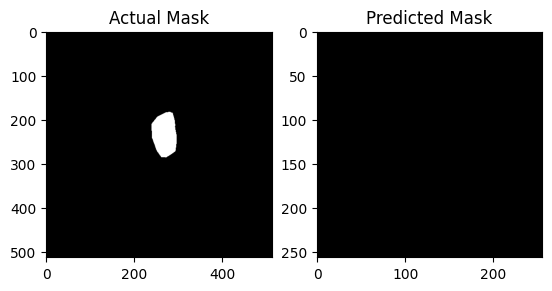

In [35]:
plt.subplot(1,2,1),plt.imshow(masked,cmap='gray'),plt.title("Actual Mask")
plt.subplot(1,2,2),plt.imshow(out,cmap='gray'),plt.title("Predicted Mask")

In [33]:
val_loss = [0.2768, 0.2670, 0.1978, 0.1704, 0.2036, 0.1623, 0.1683, 0.1610, 0.1901, 0.1904,
 0.1529, 0.1739, 0.1326, 0.1566, 0.1570, 0.1164, 0.1230, 0.1332, 0.1293, 0.1044,
 0.1412, 0.1127, 0.1136, 0.1027, 0.1033, 0.1143, 0.1265, 0.1081, 0.1058, 0.1159,
 0.1033, 0.1081, 0.0992, 0.1000, 0.1073, 0.0948, 0.0891, 0.0904, 0.0908, 0.1020,
 0.0896, 0.0878, 0.0915, 0.0876, 0.0942, 0.0828, 0.0886, 0.0867, 0.0907, 0.0853,
 0.0808, 0.0800, 0.0840, 0.0791, 0.0798, 0.0868, 0.0843, 0.0814, 0.0822, 0.0800,
 0.0817, 0.0786, 0.0851, 0.0881, 0.0783, 0.0794, 0.0798, 0.0789, 0.0764, 0.0800,
 0.0753, 0.0785, 0.0762, 0.0792, 0.0793, 0.0795, 0.0765, 0.0791, 0.0779, 0.0765,
 0.0782, 0.0766, 0.0773, 0.0797, 0.0775, 0.0815, 0.0787, 0.0788, 0.0821, 0.0768,
 0.0789, 0.0748, 0.0780, 0.0774, 0.0779, 0.0766, 0.0795, 0.0796, 0.0814, 0.0819]

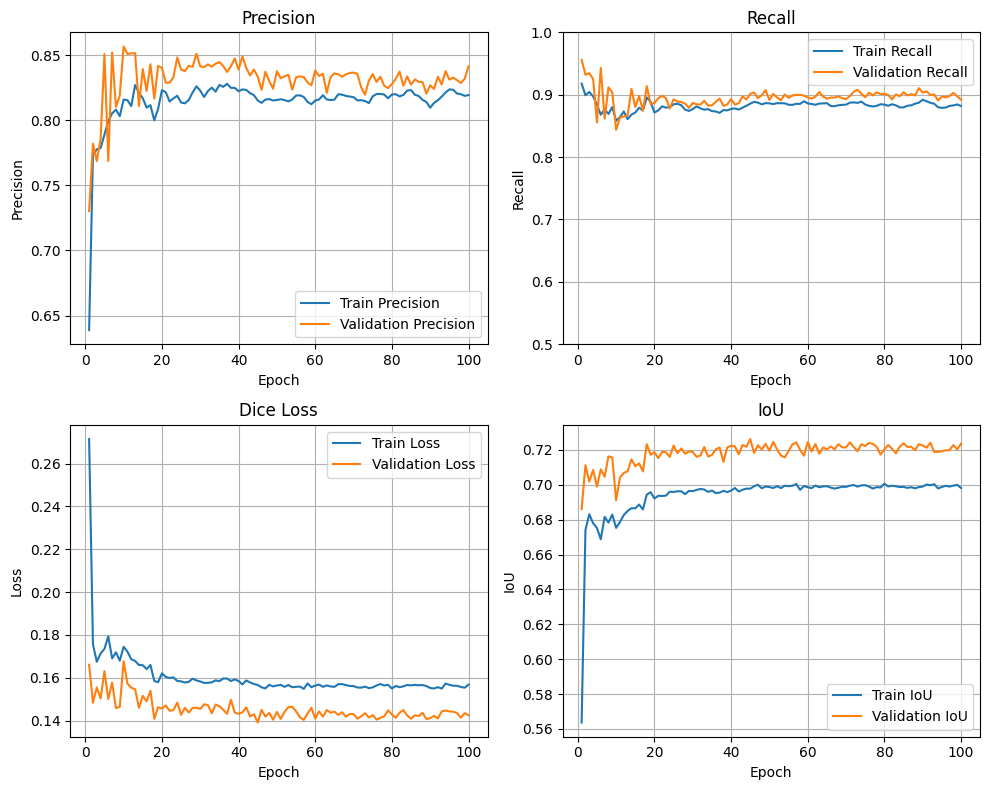

In [43]:
import matplotlib.pyplot as plt

epochs = range(1, 101)

plt.figure(figsize=(10, 8))

# Precision
plt.subplot(2, 2, 1)
plt.plot(epochs, train_prec, label='Train Precision')
plt.plot(epochs, val_prec, label='Validation Precision')
plt.title('Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

# Recall
plt.subplot(2, 2, 2)
plt.plot(epochs, train_recal, label='Train Recall')
plt.plot(epochs, val_recal, label='Validation Recall')
plt.title('Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.ylim([0.5,1])
plt.legend()
plt.grid(True)

# Dice Loss
plt.subplot(2, 2, 3)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Dice Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# IoU
plt.subplot(2, 2, 4)
plt.plot(epochs, train_iou, label='Train IoU')
plt.plot(epochs, val_iou, label='Validation IoU')
plt.title('IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("figure1.png", dpi=300, bbox_inches='tight')
plt.show()


In [44]:
torch.save(decoder.state_dict(),'EfficientSegnet_weights_with_vit.pth')

In [36]:
img = transform(image)
img = img.unsqueeze(0).to(device)
out = decoder(img)

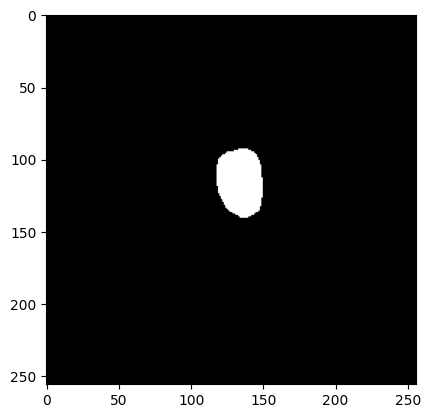

In [37]:
pred = out[0].detach().cpu().squeeze(0).permute(1,2,0).numpy()
plt.imshow(pred,cmap='gray')

(<Axes: title={'center': 'Predicted Mask'}>,
 Text(0.5, 1.0, 'Predicted Mask'))

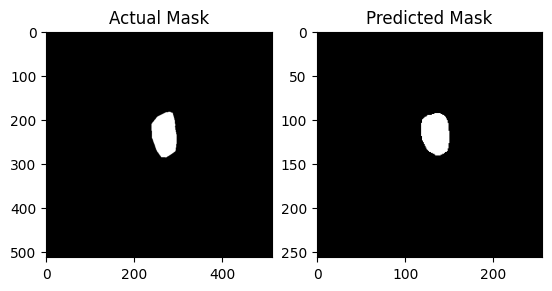

In [39]:
plt.subplot(1,2,1),plt.imshow(masked,cmap='gray'),plt.title('Actual Mask')
plt.subplot(1,2,2),plt.imshow(pred,cmap='gray'),plt.title('Predicted Mask')

In [59]:
def crop_img_mask(img, boxes, pred=True):
    cropped_images = []

    B, C, H, W = img.shape

    for i in range(B):
        if pred:
            box = boxes[i].detach().cpu().numpy()  # (4,)
        else:
            box = boxes                              # (4,)

        x1 = int(box[0] * W)
        y1 = int(box[1] * H)
        x2 = int(box[2] * W)
        y2 = int(box[3] * H)

        x1, x2 = max(0, x1), min(W, x2)
        y1, y2 = max(0, y1), min(H, y2)

        if x2 <= x1 or y2 <= y1:
            raise ValueError(f"Invalid box: {box}")

        cropped = img[i, :, y1:y2, x1:x2]
        cropped = transforms.Resize((256, 256))(cropped)
        cropped_images.append(cropped)

    return torch.stack(cropped_images)


In [61]:
import random
img_arr = []
for i in range(8):
    a = random.choice(files)
    img,mask = load_mat_image(a)
    aug = train_transform(image = img,mask = mask)
    m = aug['mask'].unsqueeze(0).float()
    img = vit_transform(aug['image'])
    img = img.unsqueeze(0).to(device)
    pred_box = model(img)
    gt_box = box_coord_pred(m)
    m = m.unsqueeze(0).float()
    cut = crop_img_mask(m,gt_box,pred = False)
    cut_img = crop_img_mask(img,pred_box,pred = True)
    x = x.to(device)
    out = decoder(x)
    x = x.detach().cpu().squeeze(0).numpy()
    pred = out[0].detach().cpu().squeeze(0).permute(1,2,0).numpy()
    img_arr.append([x,cut,pred])

NameError: name 'x' is not defined

In [ ]:
a = random.choice(files)
img, mask = load_mat_image(a)

aug = train_transform(image=img, mask=mask)

seg_img = aug['image'].unsqueeze(0).to(device)  # (1,3,H,W)

seg_mask = torch.as_tensor(aug['mask'])
if seg_mask.ndim == 2:
    seg_mask = seg_mask.unsqueeze(0).unsqueeze(0)
else:
    seg_mask = seg_mask.permute(2,0,1).unsqueeze(0)
seg_mask = seg_mask.float()

vit_img = vit_transform(aug['image']).unsqueeze(0).to(device)

pred_box = model(vit_img)        # (1,4)
gt_box   = box_coord_pred(seg_mask)

cut_mask = crop_img_mask(seg_mask, gt_box, pred=False)
cut_img  = crop_img_mask(seg_img, pred_box, pred=True)

out = decoder(cut_img)
pred = out[0].detach().cpu().squeeze(0).permute(1,2,0).numpy()


NameError: name 'sample_arr' is not defined

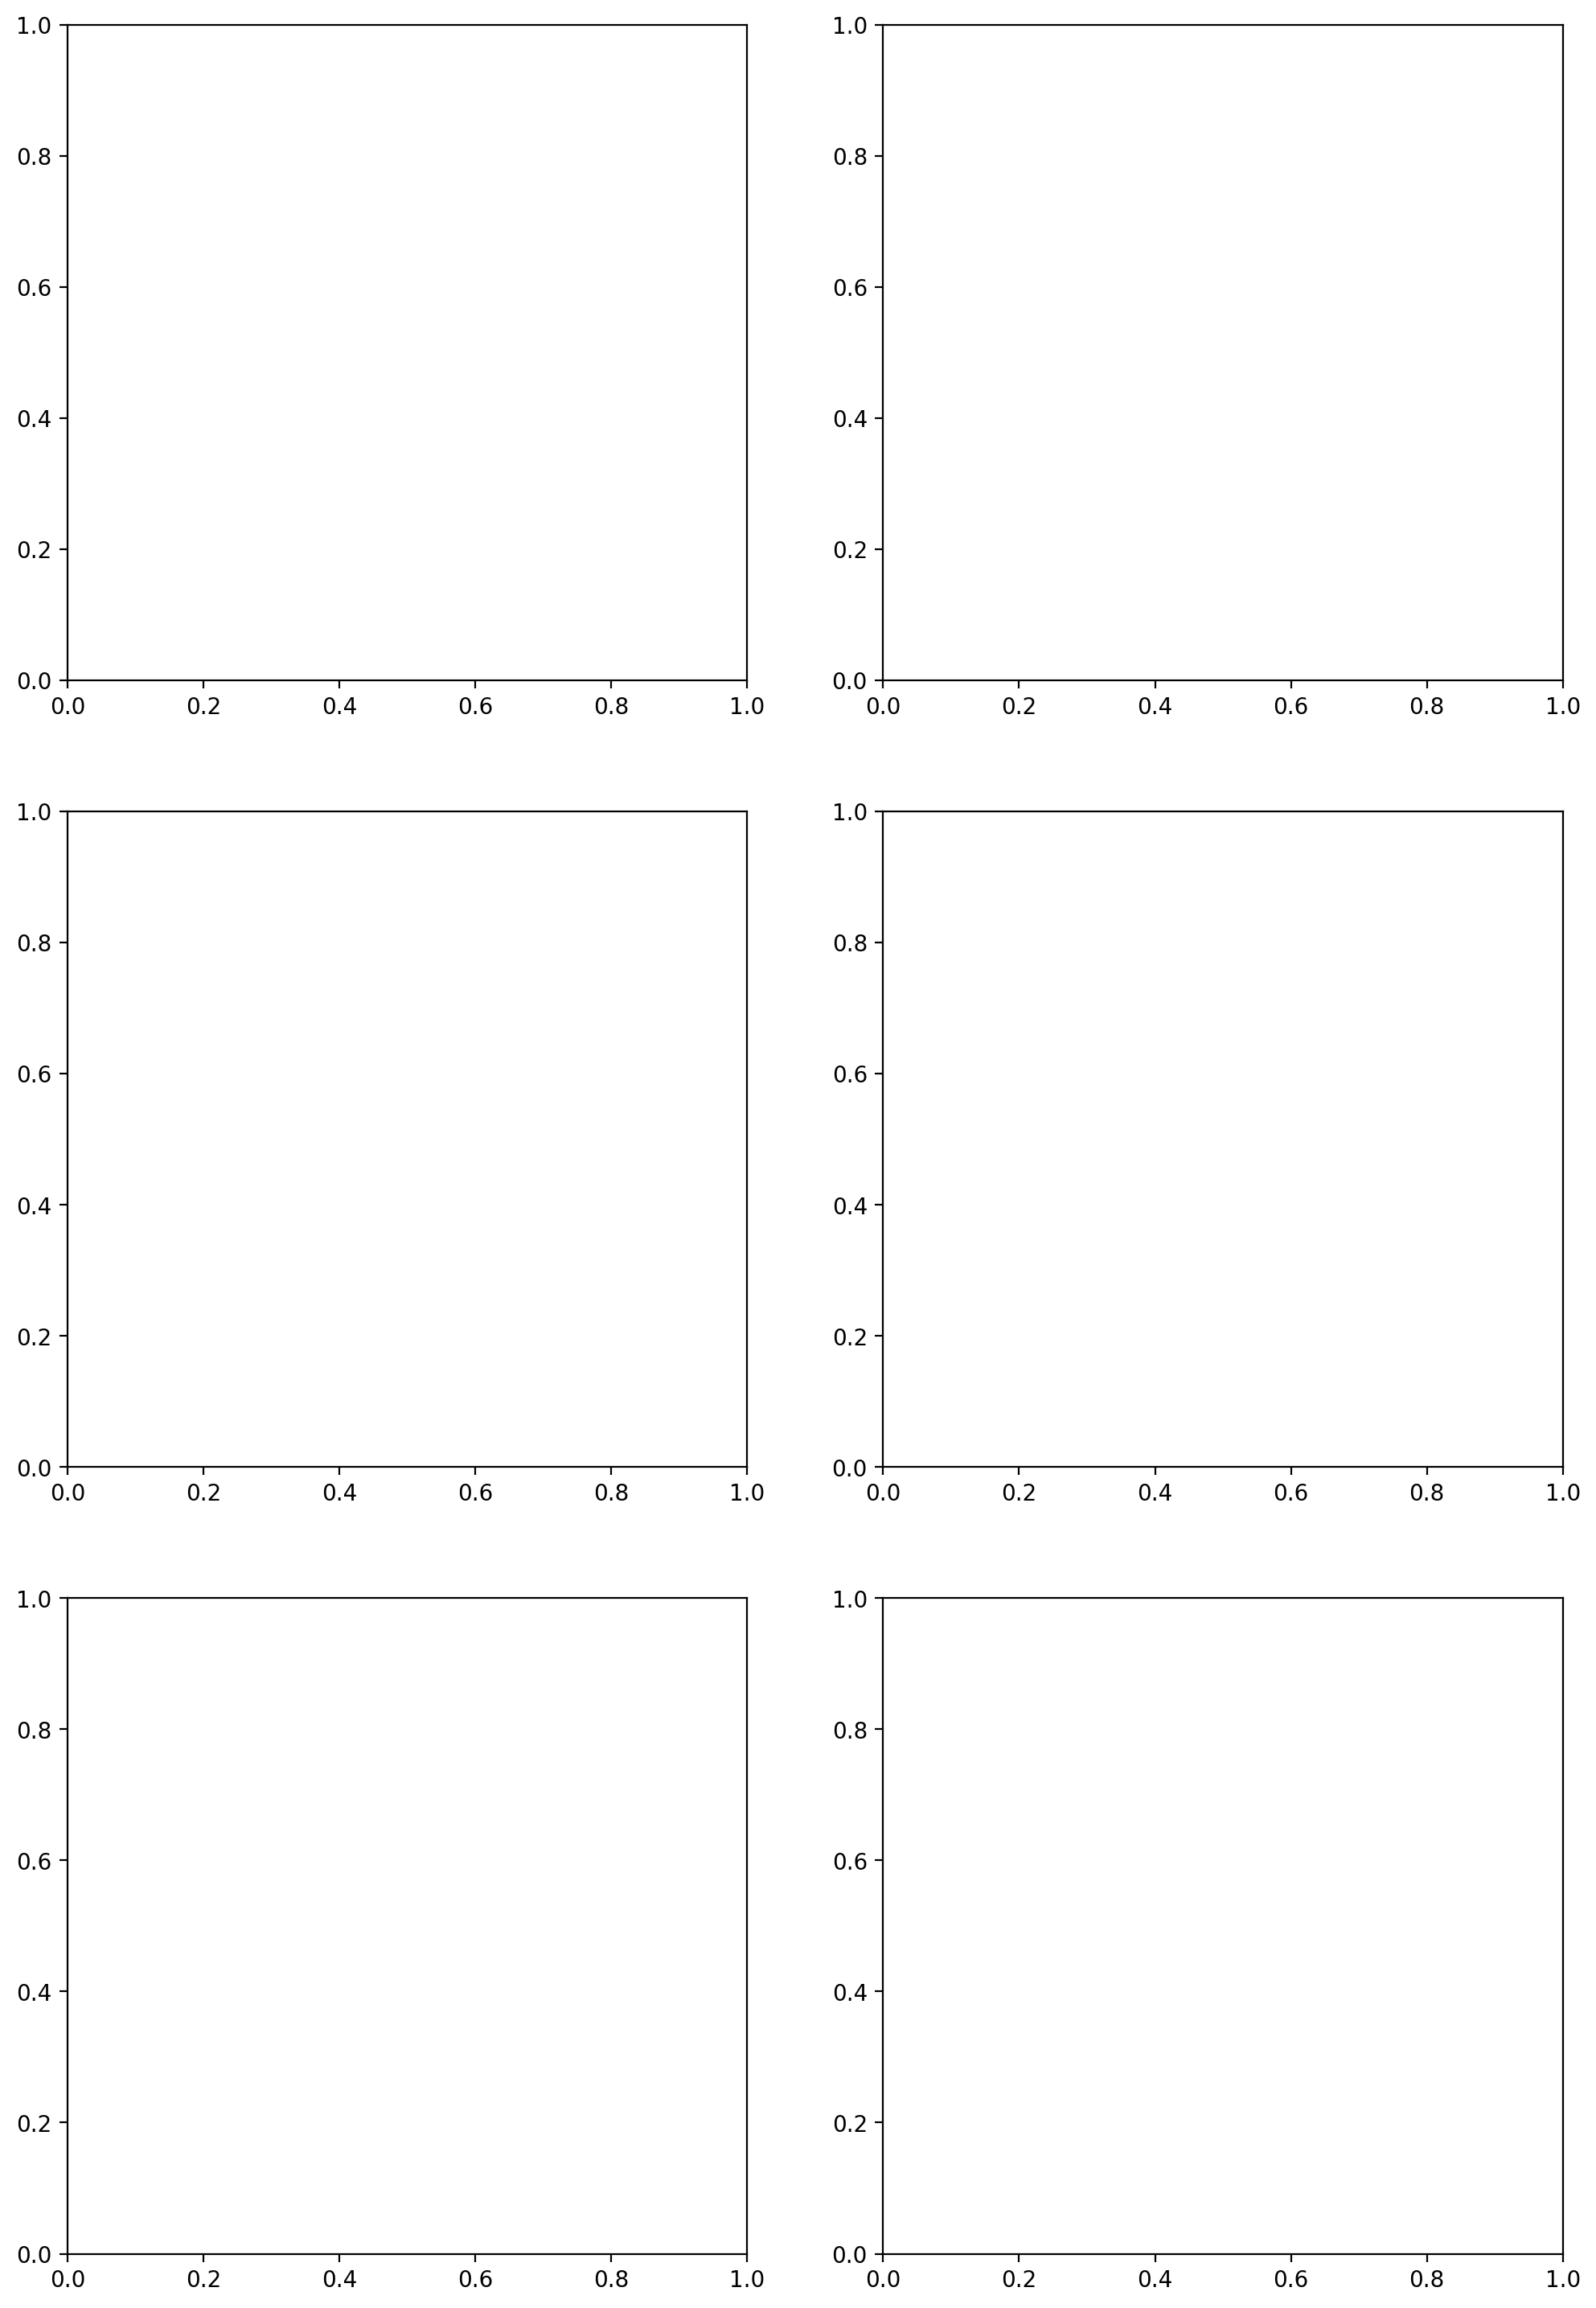

In [56]:
rows = 3
cols = 2

fig, axes = plt.subplots(rows, cols, figsize=(12, 18), dpi=200)

for i in range(rows):
    for j in range(cols):
        axes[i, j].imshow(sample_arr[i][j], cmap='gray')
        axes[i, j].axis('off')

plt.tight_layout(pad=1)
plt.savefig("figure.png", dpi=300, bbox_inches='tight')
plt.show()

In [47]:
pth = os.path.join('/kaggle/input/extra-brain-images')
print(os.listdir(pth))

['sample_brain1.jpeg', 'sample_brain2.jpeg', 'sample_brain.jpeg']


In [64]:
sample_arr = []
for i in os.listdir(pth):
    img = cv.imread(os.path.join(pth,i))
    img = cv.resize(img,(256,256))
    x = torch.from_numpy(img).to(device)
    x = x.permute(2,0,1)
    x = x.unsqueeze(0)
    x = x.to(torch.float32)
    out = decoder(x)
    pred = out[0].detach().cpu().squeeze(0).permute(1,2,0).numpy()
    sample_arr.append([img,pred])